In [1]:
from nerf_model import NerfModel
import torch
import torch.nn as nn
from tqdm import tqdm
from thop import profile
from torchprofile import profile_macs
import matplotlib.pyplot as plt
import numpy as np

import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

In [2]:
# model = NerfModel()

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please try to use GPU from WPI turing server or google colab"
import torch
torch.cuda.empty_cache()
device = "cuda"

In [3]:
# Dummy inputs for MACs and testing (e.g., batch size = 1)
x_dummy = torch.randn(1, 3)  # (B, 3)
d_dummy = torch.randn(1, 3)  # (B, 3)


# Modify get_model_macs to work with multiple inputs
def get_model_macs(model, inputs):
    model.eval()
    macs, _ = profile(model, inputs=(inputs,))
    return macs

def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [4]:
# macs = get_model_macs(model, (x_dummy, d_dummy))
# print(f"MACs: {macs}")

In [5]:
checkpoint_path = "./nerf_model_final.pth"
print(f"Loading model from checkpoint: {checkpoint_path}")
checkpoint = torch.load(checkpoint_path, map_location=device)

model = NerfModel(hidden_dim=256).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
# model_pth = torch.load(checkpoint_path, map_location="cpu")

model = model.cuda()
# print(f"=> loading checkpoint '{model_path}'")
# model.load_state_dict(model_pth['model_state_dict'])
# recover_model = lambda: model.load_state_dict(model_pth['model_state_dict'])


Loading model from checkpoint: ./nerf_model_final.pth


/tmp/ipykernel_9152/2403868998.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


# Load Train, Val and Test data

# Also Evaluate the Accuracy and Model Size of Dense Model

In [6]:
import torch
import numpy as np
import pickle
from torch.utils.data import Dataset, DataLoader
import os

class NeRFDataset(Dataset):
    """Custom Dataset for loading NeRF data from pickle files"""
    
    def __init__(self, pickle_file, transform=None):
        """
        Args:
            pickle_file: Path to the pickle file
            transform: Optional transform to be applied on a sample
        """
        # Load the data from pickle file
        with open(pickle_file, 'rb') as f:
            self.data = pickle.load(f)
        
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        
        # Extract ray origins, directions, and RGB values
        ray_origins = sample[:3]
        ray_directions = sample[3:6]
        rgb_values = sample[6:9]
        
        # Convert to tensors
        ray_origins = torch.tensor(ray_origins, dtype=torch.float32)
        ray_directions = torch.tensor(ray_directions, dtype=torch.float32)
        rgb_values = torch.tensor(rgb_values, dtype=torch.float32)
        
        # Apply transforms if any
        if self.transform:
            rgb_values = self.transform(rgb_values)
        
        return {
            'ray_origins': ray_origins,
            'ray_directions': ray_directions,
            'rgb_values': rgb_values
        }

# Create data loaders
def create_nerf_dataloaders(data_dir, batch_size=4096, shuffle_train=True, num_workers=0):
    """
    Create data loaders for NeRF training and validation
    
    Args:
        data_dir: Directory containing the pickle files
        batch_size: Batch size for training
        shuffle_train: Whether to shuffle the training data
        num_workers: Number of worker threads for data loading
        
    Returns:
        Dictionary of data loaders for 'train' and 'val' splits
    """
    dataset = {}
    dataloader = {}
    
    # Define file paths
    file_paths = {
        'train': os.path.join(data_dir, 'training_data.pkl'),
        'val': os.path.join(data_dir, 'val_data.pkl'),
        'test': os.path.join(data_dir, 'testing_data.pkl')
    }
    
    # Create datasets
    for split in ['train', 'val','test']:
        if os.path.exists(file_paths[split]):
            dataset[split] = NeRFDataset(
                pickle_file=file_paths[split],
                transform=None  # You can add transforms if needed
            )
            
            dataloader[split] = DataLoader(
                dataset[split],
                batch_size=batch_size,
                shuffle=(split == 'train' and shuffle_train),
                num_workers=num_workers,
                pin_memory=True
            )
        else:
            print(f"Warning: {file_paths[split]} not found. Skipping {split} dataloader.")
    
    return dataloader

# Example usage
if __name__ == "__main__":
    # Replace with your actual data directory
    data_dir = "./Dataset"
    
    dataloader = create_nerf_dataloaders(
        data_dir=data_dir,
        batch_size=1024,  # Typical batch size for NeRF training
        shuffle_train=True,
        num_workers=4
    )
    
    # Check the data loaders
    for split, loader in dataloader.items():
        if loader:
            sample_batch = next(iter(loader))
            print(f"\n{split} dataloader:")
            for key, value in sample_batch.items():
                print(f"- {key}: shape {value.shape}, type {type(value)}")


train dataloader:
- ray_origins: shape torch.Size([1024, 3]), type <class 'torch.Tensor'>
- ray_directions: shape torch.Size([1024, 3]), type <class 'torch.Tensor'>
- rgb_values: shape torch.Size([1024, 3]), type <class 'torch.Tensor'>

val dataloader:
- ray_origins: shape torch.Size([1024, 3]), type <class 'torch.Tensor'>
- ray_directions: shape torch.Size([1024, 3]), type <class 'torch.Tensor'>
- rgb_values: shape torch.Size([1024, 3]), type <class 'torch.Tensor'>

test dataloader:
- ray_origins: shape torch.Size([1024, 3]), type <class 'torch.Tensor'>
- ray_directions: shape torch.Size([1024, 3]), type <class 'torch.Tensor'>
- rgb_values: shape torch.Size([1024, 3]), type <class 'torch.Tensor'>


In [7]:
@torch.inference_mode()
def evaluate(
    model: nn.Module,
    dataloader: DataLoader, threshold=0.05,
    verbose=True,
) -> float:
    model.eval()

    total_loss = 0
    total_samples = 0
    loss_count=0
    for batch in tqdm(dataloader, desc="eval", leave=False, disable=not verbose):
        # Handle dictionary output from the dataloader
        rgb_values = batch['rgb_values'].cuda()
        ray_origins = batch['ray_origins'].cuda()
        ray_directions = batch['ray_directions'].cuda()

        # Inference - only pass the parameters your model expects
        colors, sigma = model(ray_origins, ray_directions)  # Now matches your model's expected inputs
        
        # Compute L2 loss on the colors (RGB values)
        loss = (colors - rgb_values)
        loss_count += (loss.abs() > threshold).sum().item()

        total_samples += rgb_values.shape[0]

    acc = loss_count / total_samples

    if verbose:
        print(f'Average loss: {acc*100:.6f}')

    return acc


model.eval()

dense_model_accuracy = evaluate(model, dataloader['val'],0.05)
dense_model_size = get_model_size(model)
print(f"dense model has accuracy: {dense_model_accuracy:.2f}%")
print(f"dense model has size: {dense_model_size/MiB:.2f} MiB")

Average loss: 83.970625
dense model has accuracy: 0.84%
dense model has size: 2.02 MiB


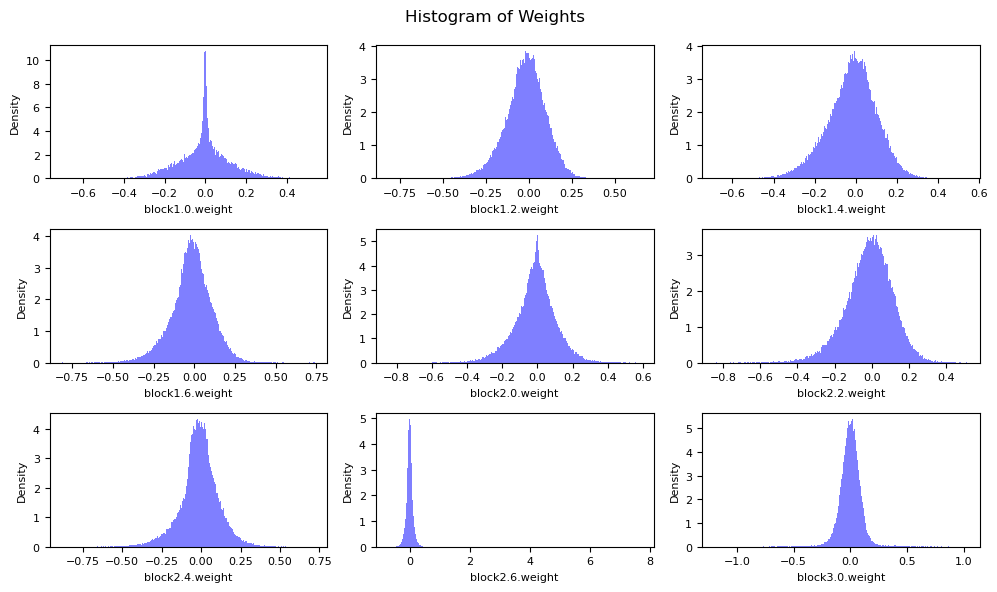

In [8]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3, 3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0

    for name, param in model.named_parameters():
        if param.dim() > 1:  # Ignore bias terms (which are 1D)
            ax = axes[plot_index]
            param_cpu = param.detach().view(-1).cpu().numpy()  # Flatten weights and convert to NumPy

            if count_nonzero_only:
                param_cpu = param_cpu[param_cpu != 0]  # Keep only nonzero values

            ax.hist(param_cpu, bins=bins, density=True, color='blue', alpha=0.5)  # Plot histogram
            
            ax.set_xlabel(name, fontsize=8)
            ax.set_ylabel('Density', fontsize=8)
            ax.tick_params(axis='both', which='major', labelsize=8)
            
            plot_index += 1
            if plot_index >= len(axes):  # Avoid index error
                break

    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    plt.show()

# Call the function to visualize weight distributions
plot_weight_distribution(model)

In [9]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()
    ##################### YOUR CODE STARTS HERE #####################
    
    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(num_elements*sparsity)

    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)

    # Step 3: calculate the pruning threshold
    if num_zeros > 0:
        threshold, _ = torch.kthvalue(importance.view(-1), num_zeros)
    else:
        threshold = torch.tensor(0.0, device=tensor.device)
    # print(threshold[0])

    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = torch.gt(importance, threshold).float()

    # print(mask)
    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

In [10]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

In [11]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

In [12]:
# sparsities, accuracies = sensitivity_scan(
#     model, dataloader['test'], scan_step=0.1, scan_start=0.4, scan_end=1.0)

In [13]:
# def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
#     lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
#     fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(15,8))
#     axes = axes.ravel()
#     plot_index = 0
#     for name, param in model.named_parameters():
#         if param.dim() > 1:
#             ax = axes[plot_index]
#             curve = ax.plot(sparsities, accuracies[plot_index])
#             line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
#             ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
#             ax.set_ylim(0, 80)
#             ax.set_title(name)
#             ax.set_xlabel('sparsity')
#             ax.set_ylabel('top-1 accuracy')
#             ax.legend([
#                 'accuracy after pruning',
#                 f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
#             ])
#             ax.grid(axis='x')
#             plot_index += 1
#     fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
#     fig.tight_layout()
#     fig.subplots_adjust(top=0.7800)
#     plt.show()

# plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

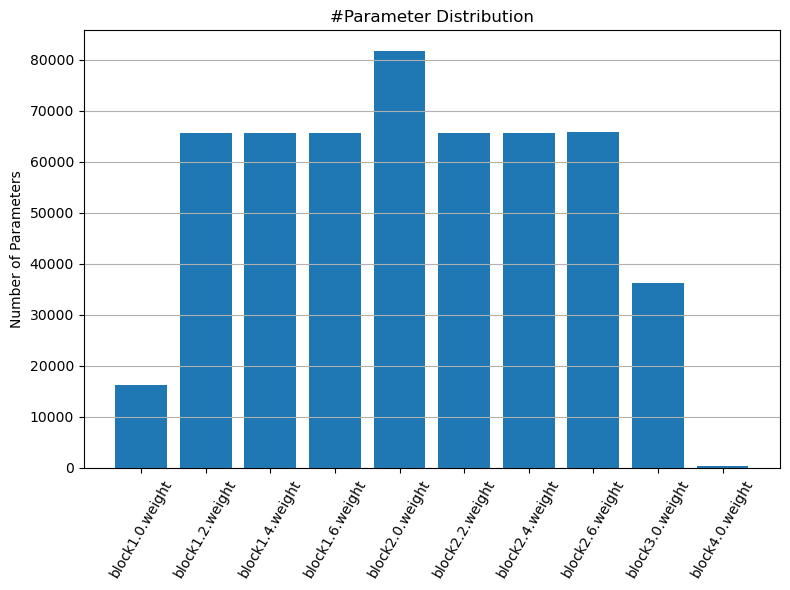

In [14]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

In [15]:
# # recover_model()

# sparsity_dict = {
# ##################### YOUR CODE STARTS HERE #####################
#     # please modify the sparsity value of each layer
#     # please DO NOT modify the key of sparsity_dict

#     'block1.0.weight': 0.20,   #Small layer, less pruning
#     'block1.2.weight': 0.50,   #Small layer, less pruning
#     'block1.4.weight': 0.50,   #Slightly larger, more pruning
#     'block1.6.weight': 0.50,   #Medium layer, significant pruning
#     'block2.0.weight': 0.55,   #Large layer, but also sensitive, moderate pruning
#     'block2.2.weight': 0.50,
#     'block2.4.weight': 0.50,   #Large layer, but also sensitive, moderate pruning
#     'block2.6.weight': 0.50,   #Largest layer, highest pruning
#     'block3.0.weight': 0.40,   #Largest layer, highest pruning
#     'block4.0.weight': 0.00        #FC Layer, moderate pruning

# ##################### YOUR CODE ENDS HERE #######################
# }

In [16]:
# pruner = FineGrainedPruner(model, sparsity_dict)
# print(f'After pruning with sparsity dictionary')
# for name, sparsity in sparsity_dict.items():
#     print(f'  {name}: {sparsity:.2f}')
# print(f'The sparsity of each layer becomes')
# for name, param in model.named_parameters():
#     if name in sparsity_dict:
#         print(f'  {name}: {get_sparsity(param):.2f}')

# sparse_model_size = get_model_size(model, count_nonzero_only=True)
# print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
# sparse_model_accuracy = evaluate(model, dataloader['test'])
# print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

# plot_weight_distribution(model, count_nonzero_only=True)

# Change the Fine-tuning for NeRF

In [17]:
# num_finetune_epochs = 5
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
# criterion = nn.CrossEntropyLoss()

# best_sparse_model_checkpoint = dict()
# best_accuracy = 0
# print(f'Finetuning Fine-grained Pruned Sparse Model')
# for epoch in range(num_finetune_epochs):
#     # At the end of each train iteration, we have to apply the pruning mask 
#     #    to keep the model sparse during the training
#     train(model, dataloader['train'], criterion, optimizer, scheduler,
#           callbacks=[lambda: pruner.apply(model)])
#     accuracy = evaluate(model, dataloader['test'])
#     is_best = accuracy > best_accuracy
#     if is_best:
#         best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
#         best_accuracy = accuracy
#     print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

In [18]:
# # load the best sparse model checkpoint to evaluate the final performance
# model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
# sparse_model_size = get_model_size(model, count_nonzero_only=True)
# print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
# sparse_model_accuracy = evaluate(model, dataloader['test'])
# print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fine-tuning")

In [19]:
# def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
#     """A function to calculate the number of layers to PRESERVE after pruning
#     Note that preserve_rate = 1. - prune_ratio
#     """
#     ##################### YOUR CODE STARTS HERE #####################
#     preserve_rate = 1.0 - prune_ratio
#     return int(round(channels*preserve_rate))
#     ##################### YOUR CODE ENDS HERE #####################

# @torch.no_grad()
# def channel_prune(model: nn.Module, 
#                   prune_ratio: Union[List, float]) -> nn.Module:
#     """Apply channel pruning to each of the conv layer in the backbone
#     Note that for prune_ratio, we can either provide a floating-point number,
#     indicating that we use a uniform pruning rate for all layers, or a list of
#     numbers to indicate per-layer pruning rate.
#     """
#     # sanity check of provided prune_ratio
#     assert isinstance(prune_ratio, (float, list))
#     n_conv = len([m for m in model.backbone if isinstance(m, nn.Conv2d)])
#     # note that for the ratios, it affects the previous conv output and next
#     # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
#     if isinstance(prune_ratio, list):
#         assert len(prune_ratio) == n_conv - 1
#     else:  # convert float to list
#         prune_ratio = [prune_ratio] * (n_conv - 1)

#     # we prune the convs in the backbone with a uniform ratio
#     model = copy.deepcopy(model)  # prevent overwrite
#     # we only apply pruning to the backbone features
#     all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
#     all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
#     # apply pruning. we naively keep the first k channels
#     assert len(all_convs) == len(all_bns)
#     for i_ratio, p_ratio in enumerate(prune_ratio):
#         prev_conv = all_convs[i_ratio]
#         prev_bn = all_bns[i_ratio]
#         next_conv = all_convs[i_ratio + 1]
#         original_channels = prev_conv.out_channels  # same as next_conv.in_channels
#         n_keep = get_num_channels_to_keep(original_channels, p_ratio)

#         # prune the output of the previous conv and bn
#         prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
#         prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
#         prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
#         prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
#         prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])

#         # prune the input of the next conv (hint: just one line of code).
#         ##################### YOUR CODE STARTS HERE #####################
#         next_conv.weight.data = next_conv.weight.data[:, :n_keep]
        
#         ##################### YOUR CODE ENDS HERE #####################

#     return model


In [20]:
# dummy_input = torch.randn(1, 3, 32, 32).cuda()
# pruned_model = channel_prune(model, prune_ratio=0.3).cuda()
# pruned_macs = get_model_macs(pruned_model, dummy_input)
# assert pruned_macs == 305388064
# print('* Check passed. Right MACs for the pruned model.')

In [21]:
# pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
# print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

In [22]:
# # function to sort the channels from important to non-important
# def get_input_channel_importance(weight):
#     in_channels = weight.shape[1]
#     importances = []
#     # compute the importance for each input channel
#     for i_c in range(weight.shape[1]):
#         channel_weight = weight.detach()[:, i_c]
#         ##################### YOUR CODE STARTS HERE #####################
#         importance = torch.norm(channel_weight, p=2)
#         ##################### YOUR CODE ENDS HERE #####################
#         importances.append(importance.view(1))
#     return torch.cat(importances)

# @torch.no_grad()
# def apply_channel_sorting(model):
#     model = copy.deepcopy(model)  # do not modify the original model
#     # fetch all the conv and bn layers from the backbone
#     all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
#     all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
#     # iterate through conv layers
#     for i_conv in range(len(all_convs) - 1):
#         # each channel sorting index, we need to apply it to:
#         # - the output dimension of the previous conv
#         # - the previous BN layer
#         # - the input dimension of the next conv (we compute importance here)
#         prev_conv = all_convs[i_conv]
#         prev_bn = all_bns[i_conv]
#         next_conv = all_convs[i_conv + 1]
#         # note that we always compute the importance according to input channels
#         importance = get_input_channel_importance(next_conv.weight)
#         # sorting from large to small
#         sort_idx = torch.argsort(importance, descending=True) 

#         # apply to previous conv and its following bn
#         prev_conv.weight.copy_(torch.index_select(
#             prev_conv.weight.detach(), 0, sort_idx))
#         for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
#             tensor_to_apply = getattr(prev_bn, tensor_name)
#             tensor_to_apply.copy_(
#                 torch.index_select(tensor_to_apply.detach(), 0, sort_idx)
#             )
        
#         # apply to the next conv input (hint: one line of code)
#         ##################### YOUR CODE STARTS HERE #####################
#         # next_conv.weight.copy_(0)
#         next_conv.weight.data = next_conv.weight.data[:, sort_idx]
#         ##################### YOUR CODE ENDS HERE #####################

#     return model

In [23]:
# print('Before sorting...')
# dense_model_accuracy = evaluate(model, dataloader['test'])
# print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

# print('After sorting...')
# sorted_model = apply_channel_sorting(model)
# sorted_model_accuracy = evaluate(sorted_model, dataloader['test'])
# print(f"sorted model has accuracy={sorted_model_accuracy:.2f}%")

# # make sure accuracy does not change after sorting, since it is 
# # equivalent transform
# assert abs(sorted_model_accuracy - dense_model_accuracy) < 0.1
# print('* Check passed.')

In [24]:
# channel_pruning_ratio = 0.3  # pruned-out ratio

# print(" * Without sorting...")
# pruned_model = channel_prune(model, channel_pruning_ratio)
# pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
# print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


# print(" * With sorting...")
# sorted_model = apply_channel_sorting(model)
# pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
# pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
# print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

In [25]:
# num_finetune_epochs = 5
# optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
# criterion = nn.CrossEntropyLoss()

# best_accuracy = 0
# for epoch in range(num_finetune_epochs):
#     train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
#     accuracy = evaluate(pruned_model, dataloader['test'])
#     is_best = accuracy > best_accuracy
#     if is_best:
#         best_accuracy = accuracy
#     print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

In [26]:
# # helper functions to measure latency of a regular PyTorch models. 
# #   Unlike fine-grained pruning, channel pruning
# #   can directly leads to model size reduction and speed up.
# @torch.no_grad()
# def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
#     model.eval()
#     # warmup
#     for _ in range(n_warmup):
#         _ = model(dummy_input)
#     # real test
#     t1 = time.time()
#     for _ in range(n_test):
#         _ = model(dummy_input)
#     t2 = time.time()
#     return (t2 - t1) / n_test  # average latency

# table_template = "{:<15} {:<15} {:<15} {:<15}"
# print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# # 1. measure the latency of the original model and the pruned model on CPU
# #   which simulates inference on an edge device
# dummy_input = torch.randn(1, 3, 32, 32).to('cpu')
# pruned_model = pruned_model.to('cpu')
# model = model.to('cpu')

# pruned_latency = measure_latency(pruned_model, dummy_input)
# original_latency = measure_latency(model, dummy_input)
# print(table_template.format('Latency (ms)', 
#                             round(original_latency * 1000, 1), 
#                             round(pruned_latency * 1000, 1), 
#                             round(original_latency / pruned_latency, 1)))

# # 2. measure the computation (MACs)
# original_macs = get_model_macs(model, dummy_input)
# pruned_macs = get_model_macs(pruned_model, dummy_input)
# print(table_template.format('MACs (M)', 
#                             round(original_macs / 1e6), 
#                             round(pruned_macs / 1e6), 
#                             round(original_macs / pruned_macs, 1)))

# # 3. measure the model size (params)
# original_param = get_num_parameters(model)
# pruned_param = get_num_parameters(pruned_model)
# print(table_template.format('Param (M)', 
#                             round(original_param / 1e6, 2), 
#                             round(pruned_param / 1e6, 2), 
#                             round(original_param / pruned_param, 1)))

# # put model back to cuda
# pruned_model = pruned_model.to('cuda')
# model = model.to('cuda')

# Quantization

<!-- fp32_model_accuracy = evaluate(model, dataloader['test'])
fp32_model_size = get_model_size(model)
print(f"fp32 model has accuracy={fp32_model_accuracy:.2f}%")
print(f"fp32 model has size={fp32_model_size/MiB:.2f} MiB") -->

In [27]:
from collections import namedtuple

Codebook = namedtuple('Codebook', ['centroids', 'labels'])

In [28]:
from fast_pytorch_kmeans import KMeans

def k_means_quantize(fp32_tensor: torch.Tensor, bitwidth=8, codebook=None):
    """
    quantize tensor using k-means clustering
    :param fp32_tensor:
    :param bitwidth: [int] quantization bit width, default=4
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
    :return:
        [Codebook = (centroids, labels)]
            centroids: [torch.(cuda.)FloatTensor] the cluster centroids
            labels: [torch.(cuda.)LongTensor] cluster label tensor
    """
    if codebook is None:
        ############### YOUR CODE STARTS HERE ###############
        # get number of clusters based on the quantization precision
        # hint: one line of code
        n_clusters = 2**bitwidth    # Since we are using bitwidth = 2, in this case we will have 4 clusters.
        ############### YOUR CODE ENDS HERE #################

        weights_flat = fp32_tensor.detach().cpu().numpy().flatten()

        # use k-means to get the quantization centroids
        kmeans = KMeans(n_clusters=n_clusters, mode='euclidean', verbose=0)
        labels = kmeans.fit_predict(fp32_tensor.view(-1, 1)).to(torch.long)
        centroids = kmeans.centroids.to(torch.float).view(-1)
        codebook = Codebook(centroids, labels)
    ############### YOUR CODE STARTS HERE ###############
    # decode the codebook into k-means quantized tensor for inference
    # hint: one line of code
    quantized_tensor = codebook.centroids[codebook.labels]
    ############### YOUR CODE ENDS HERE #################
    fp32_tensor.set_(quantized_tensor.view_as(fp32_tensor))
    return codebook

In [29]:
from torch.nn import parameter
class KMeansQuantizer:
    def __init__(self, model : nn.Module, bitwidth=4):
        self.codebook = KMeansQuantizer.quantize(model, bitwidth)
    
    @torch.no_grad()
    def apply(self, model, update_centroids):
        for name, param in model.named_parameters():
            if name in self.codebook:
                if update_centroids:
                    update_codebook(param, codebook=self.codebook[name])
                self.codebook[name] = k_means_quantize(
                    param, codebook=self.codebook[name])

    @staticmethod
    @torch.no_grad()
    def quantize(model: nn.Module, bitwidth=4):
        codebook = dict()
        if isinstance(bitwidth, dict):
            for name, param in model.named_parameters():
                if name in bitwidth:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth[name])
        else:
            for name, param in model.named_parameters():
                if param.dim() > 1:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth)
        return codebook

In [30]:
print('Note that the storage for codebooks is ignored when calculating the model size.')
quantizers = dict()
for bitwidth in [8,4,2]:
    # recover_model()
    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer = KMeansQuantizer(model, bitwidth)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, dataloader['test'])
    print(f"    {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}%")
    
    torch.save(model.state_dict(), f"{bitwidth}bit_nerf.pth")

    quantizers[bitwidth] = quantizer

Note that the storage for codebooks is ignored when calculating the model size.
k-means quantizing model into 8 bits
    8-bit k-means quantized model has size=0.51 MiB


Average loss: 85.410391
    8-bit k-means quantized model has accuracy=0.85%
k-means quantizing model into 4 bits
    4-bit k-means quantized model has size=0.25 MiB


Average loss: 85.410391
    4-bit k-means quantized model has accuracy=0.85%
k-means quantizing model into 2 bits
    2-bit k-means quantized model has size=0.13 MiB


Average loss: 95.233328
    2-bit k-means quantized model has accuracy=0.95%


In [ ]:
# Save weights only
torch.save(model.state_dict(), "./nerf_weights.pth")

# To load:
# model = NerfModel()  # Recreate model architecture
# model.load_state_dict(torch.load("./nerf_weights.pth"))
# model.eval()

model = NerfModel(hidden_dim=256).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
